### ANALISIS CON MEDIANA EN HISTORIA DEMOGRAFICA Y DIVERGENCIA
### Usar IQR para la historia demográfica (Ne en el tiempo)
### BOOTSTRAPING EN DIVERGENCIA
### MKMA todos SMOR

In [6]:
import os
import pandas as pd
import numpy as np
from scipy.stats import sem, t
import matplotlib.pyplot as plt
import glob

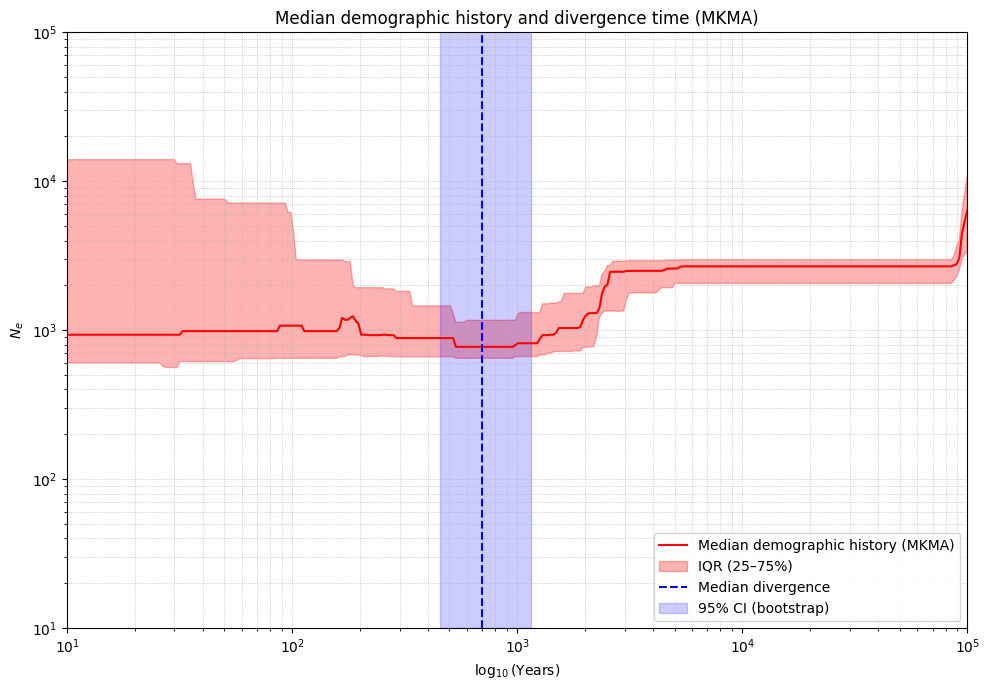

In [7]:
# 1. CONFIGURACIÓN
# Ruta base donde están las carpetas por individuo
BASE_DIR = "/home/alumno1/Nat/tremuloides/smc_divergencia/SMOR/MKMA/"
individuals = [f for f in os.listdir(BASE_DIR) if f.startswith("smc_div_MKMA")]

# Inicializar estructuras de datos
histories = []  # Para historia demográfica de cada individuo
split_records = []  # Para tiempos de divergencia

# 2. RECORRER INDIVIDUOS Y CROMOSOMAS
for indiv_folder in individuals:
    indiv_path = os.path.join(BASE_DIR, indiv_folder)
    indiv_id = indiv_folder.split("_")[-1]

    for chrom in map(str, range(1, 19)):  # Cromosomas 1 al 18
        split_file = os.path.join(indiv_path, chrom, "out", "split_analysis", "divergence_split.csv")

        if os.path.exists(split_file):
            try:
                # Leer el archivo con el separador correcto
                with open(split_file, 'r') as f:
                    first_line = f.readline()
                sep = "\t" if "\t" in first_line else ","
                df_split = pd.read_csv(split_file, sep=sep)

                # Verificar que tenga las columnas necesarias
                if not {"label", "x", "y"}.issubset(df_split.columns):
                    print(f"Formato inesperado en: {split_file} → columnas: {df_split.columns}")
                    continue

                # Identificar las poblaciones (base y divergente)
                labels = df_split['label'].unique()
                if len(labels) < 2:
                    print(f"Solo una población en {split_file}: {labels}")
                    continue

                # Separar historia base y divergente por nombre
                df_base = df_split[df_split['label'] == labels[0]].sort_values(by="x")
                df_div = df_split[df_split['label'] == labels[1]].sort_values(by="x")

                # Guardar historia demográfica de la población base
                histories.append(
                    df_base[['x', 'y']]
                    .rename(columns={"x": "time", "y": f"{indiv_id}_chr{chrom}"})
                    .set_index("time")
                )

                # Extraer el último valor de la historia de la población divergente
                time_div = df_div['x'].iloc[-1]
                ne_div = df_div['y'].iloc[-1]

                # Agregar a la tabla resumen
                split_records.append({
                    "Metapoblacion": "Sierra Madre Oriental",
                    "Poblacion": "MKMA",
                    "Individuo_Base": indiv_id,
                    "Cromosoma": chrom,
                    "Generaciones_Divergente": time_div,
                    "Ne_Divergente": ne_div
                })

            except Exception as e:
                print(f"Error procesando {split_file}: {e}")


# 3. UNIFICAR HISTORIAS DEMOGRÁFICAS usando MEDIANA
# Crear malla de tiempo común
common_time = np.logspace(-1, 5, num=500)
ne_matrix = []

for hist in histories:
    # Reindexar e interpolar cada curva sobre la malla común
    interp_ne = np.interp(common_time, hist.index.values, hist.values.flatten())
    ne_matrix.append(interp_ne)

ne_matrix = np.array(ne_matrix)

# Estadísticas robustas
median_ne = np.median(ne_matrix, axis=0)
q1_ne = np.percentile(ne_matrix, 25, axis=0)
q3_ne = np.percentile(ne_matrix, 75, axis=0)

# Usar como intervalo de confianza visual (IQR)
ci_lower = q1_ne
ci_upper = q3_ne


# 4. PROCESAR TIEMPOS DE DIVERGENCIA CON MEDIANA Y BOOTSTRAP
div_df = pd.DataFrame(split_records)  # Convertir lista de diccionarios a DataFrame

if not div_df.empty:
    data = div_df["Generaciones_Divergente"].dropna().values

    if len(data) >= 2:
        n_boot = 10000
        np.random.seed(42)  # Semilla fija para reproducibilidad
        boot_medians = [np.median(np.random.choice(data, size=len(data), replace=True)) for _ in range(n_boot)]
        median_div = np.median(data)
        ci_lower, ci_upper = np.percentile(boot_medians, [2.5, 97.5])
    else:
        median_div = data[0] if len(data) == 1 else np.nan
        ci_lower, ci_upper = np.nan, np.nan
        print("No se pudo calcular bootstrap para los tiempos de divergencia (datos insuficientes)")
else:
    median_div, ci_lower, ci_upper = np.nan, np.nan, np.nan
    print("No se encontraron tiempos de divergencia.")


# 5. GRAFICAR con mediana e intervalo intercuartílico (IQR) + IC bootstrap
plt.figure(figsize=(10, 7))

# Línea de la mediana del Ne
plt.plot(common_time, median_ne, color='red', label='Median demographic history (MKMA)')

# Relleno con el IQR
plt.fill_between(common_time, q1_ne, q3_ne, color='red', alpha=0.3, label='IQR (25–75%)')

# Línea vertical para la mediana del tiempo de divergencia
if not np.isnan(median_div):
    plt.axvline(median_div, color='blue', linestyle='--', label='Median divergence')

    # Relleno para el intervalo de confianza por bootstrap
    plt.fill_betweenx([1e1, 1e6], ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI (bootstrap)')

# Ejes logarítmicos y etiquetas
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\log_{10}$(Years)")
plt.ylabel("$N_e$")
plt.title("Median demographic history and divergence time (MKMA)")

# Leyenda y estilo
plt.legend(loc='lower right')
plt.ylim(1e1, 1e5)  # Ajusta si lo necesitas
plt.xlim(1e1, 1e5)  # Ajusta si lo necesitas
plt.grid(True, which="both", linestyle=':', linewidth=0.5)
plt.tight_layout()

# Guardar figura antes de mostrarla
plt.savefig("historia_demografica_divergencia_MKMA_years.png", dpi=300)
plt.show()


In [8]:
# Índice del tiempo más cercano a 10 años
idx_10y = (np.abs(common_time - 10)).argmin()

# Obtener la mediana de Ne en ese tiempo
ne_at_10y = median_ne[idx_10y]

# Imprimir resultados
print("\n--- Resultados resumen corregidos ---")
print(f"Mediana de tiempo de divergencia (años): {median_div:.2f}")
print(f"IC 95% bootstrap: [{ci_lower:.2f}, {ci_upper:.2f}]")
print(f"Mediana de Ne a 10 años (inicio del gráfico): {ne_at_10y:.2f}")


--- Resultados resumen corregidos ---
Mediana de tiempo de divergencia (años): 698.96
IC 95% bootstrap: [453.03, 1157.06]
Mediana de Ne a 10 años (inicio del gráfico): 932.86


In [7]:
# 6. EXPORTAR RESULTADOS
hist_df = pd.DataFrame({
    "Generaciones": common_time,
    "Ne_promedio": median_ne,
    "IC95": ci_ne
})
hist_df.to_excel("historia_promedio_MKMA.xlsx", index=False)
div_df.to_excel("divergencia_individual_MKMA.xlsx", index=False)

## CODIGO QUE TRABAJA POR INDIVIDUO a traves de la mediana en divergencia

In [9]:
import os
import pandas as pd
import numpy as np
from scipy.stats import sem, t
import matplotlib.pyplot as plt

# === CONFIGURACIÓN ===
BASE_DIR = "/home/alumno1/Nat/tremuloides/smc_divergencia/SMOR/MKMA"
individuos_base = ["MKMA-1", "MKMA-3", "MKMA-6", "MKMA-7", "MKMA-8", "MKMA-10"]
output_dir = "/home/alumno1/Nat/tremuloides/smc_divergencia/graficas_por_individuo_MKMA"
os.makedirs(output_dir, exist_ok=True)

# === MALLA DE TIEMPO COMÚN ===
common_time = np.logspace(-1, 5, num=500)

# === RECORRER INDIVIDUOS ===
for indiv in individuos_base:
    indiv_path = os.path.join(BASE_DIR, f"smc_div_MKMA_{indiv}")
    histories = []
    split_records = []

    for chrom in map(str, range(1, 19)):
        split_file = os.path.join(indiv_path, chrom, "out", "split_analysis", "divergence_split.csv")

        if os.path.exists(split_file):
            try:
                with open(split_file, 'r') as f:
                    first_line = f.readline()
                sep = "\t" if "\t" in first_line else ","
                df_split = pd.read_csv(split_file, sep=sep)

                if not {"label", "x", "y"}.issubset(df_split.columns):
                    print(f"Formato inesperado en: {split_file}")
                    continue

                labels = df_split['label'].unique()
                if len(labels) < 2:
                    continue

                df_base = df_split[df_split['label'] == labels[0]].sort_values(by="x")
                df_div = df_split[df_split['label'] == labels[1]].sort_values(by="x")

                histories.append(
                    df_base[['x', 'y']]
                    .rename(columns={"x": "time", "y": f"{indiv}_chr{chrom}"})
                    .set_index("time")
                )

                time_div = df_div['x'].iloc[-1]
                ne_div = df_div['y'].iloc[-1]

                split_records.append({
                    "Metapoblacion": "Sierra Madre Oriental",
                    "Poblacion": "MKMA",
                    "Individuo_Base": indiv,
                    "Cromosoma": chrom,
                    "Generaciones_Divergente": time_div,
                    "Ne_Divergente": ne_div
                })

            except Exception as e:
                print(f"Error procesando {split_file}: {e}")

    if len(histories) == 0:
        print(f"No se encontraron datos para {indiv}")
        continue

    # === INTERPOLAR Y CALCULAR MEDIANA + IQR ===
    ne_matrix = []
    for hist in histories:
        interp_ne = np.interp(common_time, hist.index.values, hist.values.flatten())
        ne_matrix.append(interp_ne)
    ne_matrix = np.array(ne_matrix)

    median_ne = np.median(ne_matrix, axis=0)
    q1_ne = np.percentile(ne_matrix, 25, axis=0)
    q3_ne = np.percentile(ne_matrix, 75, axis=0)

    # === PROCESAR DIVERGENCIA con MEDIANA + IC bootstrap ===
    div_df = pd.DataFrame(split_records)
    data = div_df["Generaciones_Divergente"].dropna().values

    if len(data) >= 2:
        n_boot = 10000
        np.random.seed(42)  # Semilla fija para reproducibilidad
        boot_medians = []
        for _ in range(n_boot):
            sample = np.random.choice(data, size=len(data), replace=True)
            boot_medians.append(np.median(sample))
        median_div = np.median(data)
        ci_lower, ci_upper = np.percentile(boot_medians, [2.5, 97.5])
    else:
        median_div = data[0] if len(data) == 1 else np.nan
        ci_lower, ci_upper = np.nan, np.nan
        print(f"No se puede calcular bootstrap CI para {indiv} (n={len(data)})")

    # === GRAFICAR ===
    plt.figure(figsize=(10, 7))
    plt.plot(common_time, median_ne, color='red', label=f'{indiv} (median)')
    plt.fill_between(common_time, q1_ne, q3_ne, color='red', alpha=0.3, label='IQR (25–75%)')

    if not np.isnan(median_div):
        plt.axvline(median_div, color='blue', linestyle='--', label='Median divergence')
        plt.fill_betweenx([1e1, 1e6], ci_lower, ci_upper, color='blue', alpha=0.2, label='CI 95% (bootstrap)')

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(r"$\log_{10}$(Years)")
    plt.ylabel("$N_e$")
    plt.title(f"Individual demographic history - {indiv}")
    plt.grid(True, which="both", linestyle=':', linewidth=0.5)
    plt.legend(loc='lower right')
    plt.ylim(1e1, 1e5)
    plt.xlim(1e1, 1e5)
    plt.tight_layout()

    # === EXPORTAR FIGURA Y DATOS ===
    plt.savefig(os.path.join(output_dir, f"historia_demografica_{indiv}.png"), dpi=300)
    plt.close()

    pd.DataFrame({
        "Generaciones": common_time,
        "Ne_mediana": median_ne,
        "IQR_q25": q1_ne,
        "IQR_q75": q3_ne
    }).to_excel(os.path.join(output_dir, f"historia_mediana_{indiv}.xlsx"), index=False)

    div_df.to_excel(os.path.join(output_dir, f"divergencia_individual_{indiv}.xlsx"), index=False)
             # === MOSTRAR RESULTADOS EN CONSOLA ===
    # Índice del tiempo más cercano a 10 años
    idx_10y = (np.abs(common_time - 10)).argmin()
    ne_at_10y = median_ne[idx_10y]

    print("\n--- Resultados resumen para", indiv, "---")
    print(f"Mediana de Ne a 10 años (presente): {ne_at_10y:.2f}")
    print(f"Mediana de tiempo de divergencia (años): {median_div:.2f}")
    print(f"IC 95% bootstrap: [{ci_lower:.2f}, {ci_upper:.2f}]")



--- Resultados resumen para MKMA-1 ---
Mediana de Ne a 10 años (presente): 1204.23
Mediana de tiempo de divergencia (años): 375.83
IC 95% bootstrap: [49.31, 1775.62]

--- Resultados resumen para MKMA-3 ---
Mediana de Ne a 10 años (presente): 885.79
Mediana de tiempo de divergencia (años): 496.47
IC 95% bootstrap: [163.69, 1293.78]

--- Resultados resumen para MKMA-6 ---
Mediana de Ne a 10 años (presente): 913.70
Mediana de tiempo de divergencia (años): 591.92
IC 95% bootstrap: [408.09, 1273.17]

--- Resultados resumen para MKMA-7 ---
Mediana de Ne a 10 años (presente): 1124.43
Mediana de tiempo de divergencia (años): 1226.35
IC 95% bootstrap: [698.96, 1569.32]

--- Resultados resumen para MKMA-8 ---
Mediana de Ne a 10 años (presente): 890.04
Mediana de tiempo de divergencia (años): 1117.87
IC 95% bootstrap: [335.64, 1836.96]

--- Resultados resumen para MKMA-10 ---
Mediana de Ne a 10 años (presente): 986.97
Mediana de tiempo de divergencia (años): 475.52
IC 95% bootstrap: [224.10, 189

### Codigo que genera un grafico con las divergencias de cada combinacion
### se debe correr primero el codigo anterior que genera graficas y resultados por individuo para poder correr este grafico unificado
### con la mediana en divergencia y bootstraping

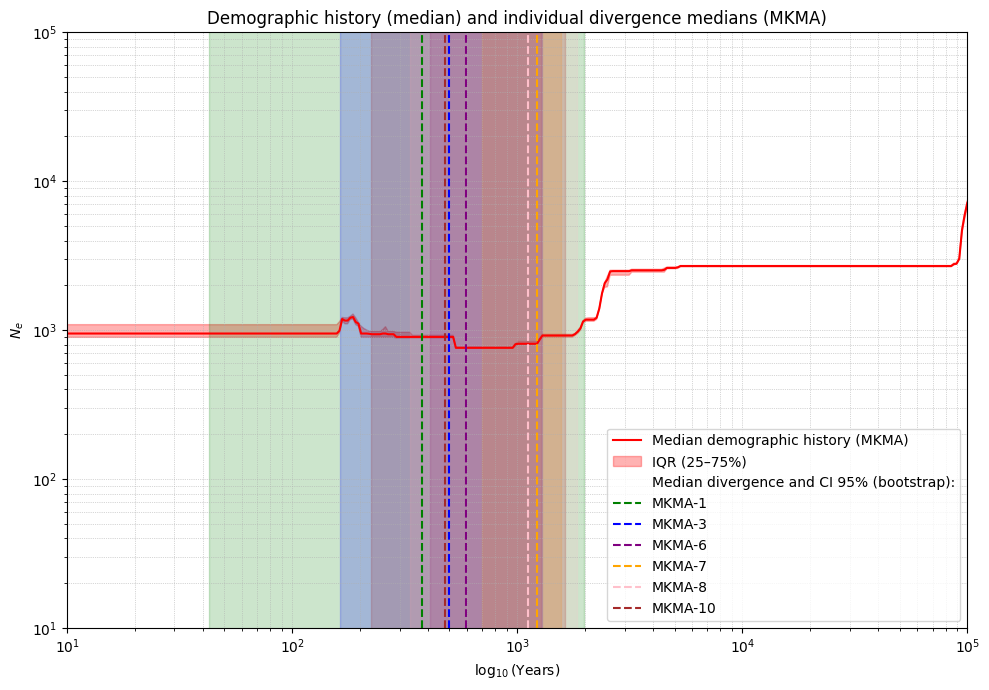

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === 1. CONFIGURACIÓN ===
indivs = ["MKMA-1", "MKMA-3", "MKMA-6", "MKMA-7", "MKMA-8", "MKMA-10"]
colors = ["green", "blue", "purple", "orange", "pink", "brown"]
common_time = np.logspace(-1, 5, num=500)

# === 2. UNIFICAR HISTORIAS INDIVIDUALES ===
ne_matrix = []

for indiv in indivs:
    file_path = f"graficas_por_individuo_MKMA/historia_mediana_{indiv}.xlsx"
    df = pd.read_excel(file_path)

    if "Generaciones" not in df.columns:
        print(f"Columna 'Generaciones' no encontrada en {file_path}")
        continue

    interp = np.interp(common_time, df["Generaciones"], df["Ne_mediana"])
    ne_matrix.append(interp)

# Calcular mediana e IQR
ne_array = np.array(ne_matrix)
median_ne = np.median(ne_array, axis=0)
q1_ne = np.percentile(ne_array, 25, axis=0)
q3_ne = np.percentile(ne_array, 75, axis=0)

# === 3. CARGAR DIVERGENCIAS POR INDIVIDUO (con mediana y bootstrap CI) ===
div_data = []

for indiv in indivs:
    file_path = f"graficas_por_individuo_MKMA/divergencia_individual_{indiv}.xlsx"
    df = pd.read_excel(file_path)
    tiempos = df["Generaciones_Divergente"].dropna().values

    if len(tiempos) >= 2:
        # Bootstrap para CI de la mediana
        n_boot = 10000
        boot_meds = [np.median(np.random.choice(tiempos, size=len(tiempos), replace=True)) for _ in range(n_boot)]
        mediana = np.median(tiempos)
        ci_low, ci_high = np.percentile(boot_meds, [2.5, 97.5])
    else:
        mediana = tiempos[0] if len(tiempos) == 1 else np.nan
        ci_low, ci_high = np.nan, np.nan
        print(f"No se puede calcular bootstrap CI para {indiv} (n={len(tiempos)})")

    div_data.append((indiv, mediana, ci_low, ci_high))

# === 4. GRAFICAR ===
plt.figure(figsize=(10, 7))

# Historia demográfica
plt.plot(common_time, median_ne, color='red', label='Median demographic history (MKMA)')
plt.fill_between(common_time, q1_ne, q3_ne, color='red', alpha=0.3, label='IQR (25–75%)')

# Línea de encabezado en la leyenda
plt.plot([], [], ' ', label='Median divergence and CI 95% (bootstrap):')

# Líneas de divergencia por individuo
for (indiv, mediana, ci_low, ci_high), color in zip(div_data, colors):
    if not np.isnan(mediana):
        plt.axvline(mediana, color=color, linestyle='--', label=f"{indiv}")
        plt.fill_betweenx([1e-1, 1e6], ci_low, ci_high, color=color, alpha=0.2)

# Ejes
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\log_{10}$(Years)")
plt.ylabel("$N_e$")
plt.title("Demographic history (median) and individual divergence medians (MKMA)")
plt.grid(True, which="both", linestyle=':', linewidth=0.5)
#plt.legend()
#plt.tight_layout()
plt.legend(loc='lower right')
plt.ylim(1e1, 1e5)  # o 1e4 según prefieras
plt.xlim(1e1, 1e5)  # o 1e4 según prefieras
plt.tight_layout()

# Guardar figura
plt.savefig("historia_divergencia_individuales_MKMA_FINAL.png", dpi=300)
plt.show()
